### Importamos las librerias

In [38]:
import ast
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import BaggingRegressor
from pydantic import BaseModel
from fastapi import FastAPI, Query, HTTPException
from enum import Enum
import pickle

### Accedemos al Dataset y realizamos EDA

In [39]:
games = []
with open('Datasets\steam_games.json') as f: #permite acceder al contenido del archivo JSON
    for line in f.readlines():
        games.append(ast.literal_eval(line)) #convirtir cada línea del archivo JSON en un diccionario de Python y añadiéndolo a la lista games

df = pd.DataFrame(games) # carga los datos en un DataFrame de pandas

In [40]:
# Ver los primeros registros del DataFrame
df.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32135 entries, 0 to 32134
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   publisher       24083 non-null  object 
 1   genres          28852 non-null  object 
 2   app_name        32133 non-null  object 
 3   title           30085 non-null  object 
 4   url             32135 non-null  object 
 5   release_date    30068 non-null  object 
 6   tags            31972 non-null  object 
 7   discount_price  225 non-null    float64
 8   reviews_url     32133 non-null  object 
 9   specs           31465 non-null  object 
 10  price           30758 non-null  object 
 11  early_access    32135 non-null  bool   
 12  id              32133 non-null  object 
 13  developer       28836 non-null  object 
 14  sentiment       24953 non-null  object 
 15  metascore       2677 non-null   object 
dtypes: bool(1), float64(1), object(14)
memory usage: 3.7+ MB


In [42]:
#Cambiar el dtype de la columna 'release_date' ya que contiene fechas en formato de texto
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

In [43]:
#Cambiar el dtype de la columna 'metascore' ya que contiene puntajes en formato de texto
df['metascore'] = pd.to_numeric(df['metascore'], errors='coerce')

In [44]:
# Verificar la estructura del dataset
df.shape

(32135, 16)

In [45]:
# Mostrar los nombres de las columnas
df.columns

Index(['publisher', 'genres', 'app_name', 'title', 'url', 'release_date',
       'tags', 'discount_price', 'reviews_url', 'specs', 'price',
       'early_access', 'id', 'developer', 'sentiment', 'metascore'],
      dtype='object')

In [46]:
# Verificar si hay valores faltantes en cada columna
df.isnull().sum()

publisher          8052
genres             3283
app_name              2
title              2050
url                   0
release_date       2352
tags                163
discount_price    31910
reviews_url           2
specs               670
price              1377
early_access          0
id                    2
developer          3299
sentiment          7182
metascore         29528
dtype: int64

In [47]:
# Reemplazar los valores de gratuidad con 0
df['price'] = df['price'].replace('Free.*', 0, regex=True)

In [48]:
# Reemplazar los valores que comienzan con 'Starting at $' por el valor numérico
df['price'] = df['price'].replace('Starting at \$', '', regex=True)

In [49]:
#Reemplazar los valores no numéricos por NaN
valores_no_num = ['Play the Demo', 'Install Theme', 'Install Now', 'Play WARMACHINE: Tactics Demo', 'Install Theme', 'Third-party', 'Play Now']
df['price'] = df['price'].replace(valores_no_num, float('nan'))

In [50]:
# Eliminamos los valores faltantes en las columnas 'price' y 'metascore'
df2 = df.dropna(subset=['price', 'metascore'])

In [51]:
#Verificar valores faltantes en la columna 'price'
df2[['price', 'metascore']].isnull().sum()

price        0
metascore    0
dtype: int64

In [52]:
# Extraer el año de la fecha y agregarlo como una nueva columna 'year'
df2['year'] = df2['release_date'].dt.year

C:\Users\unama\AppData\Local\Temp\ipykernel_23056\1011863384.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['year'] = df2['release_date'].dt.year


In [54]:
#Revisar las columnas y tipos de datos despues de los cambios
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2584 entries, 28 to 32117
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   publisher       2503 non-null   object        
 1   genres          2523 non-null   object        
 2   app_name        2584 non-null   object        
 3   title           2534 non-null   object        
 4   url             2584 non-null   object        
 5   release_date    2523 non-null   datetime64[ns]
 6   tags            2583 non-null   object        
 7   discount_price  3 non-null      float64       
 8   reviews_url     2583 non-null   object        
 9   specs           2580 non-null   object        
 10  price           2584 non-null   object        
 11  early_access    2584 non-null   bool          
 12  id              2583 non-null   object        
 13  developer       2512 non-null   object        
 14  sentiment       2564 non-null   object        
 15  metasco

In [66]:
#df2.to_csv('df2.csv', index = False)

## Visualizaciones

In [55]:
# Contar la cantidad de juegos lanzados en cada año
games_by_year = df2['year'].value_counts().sort_index()

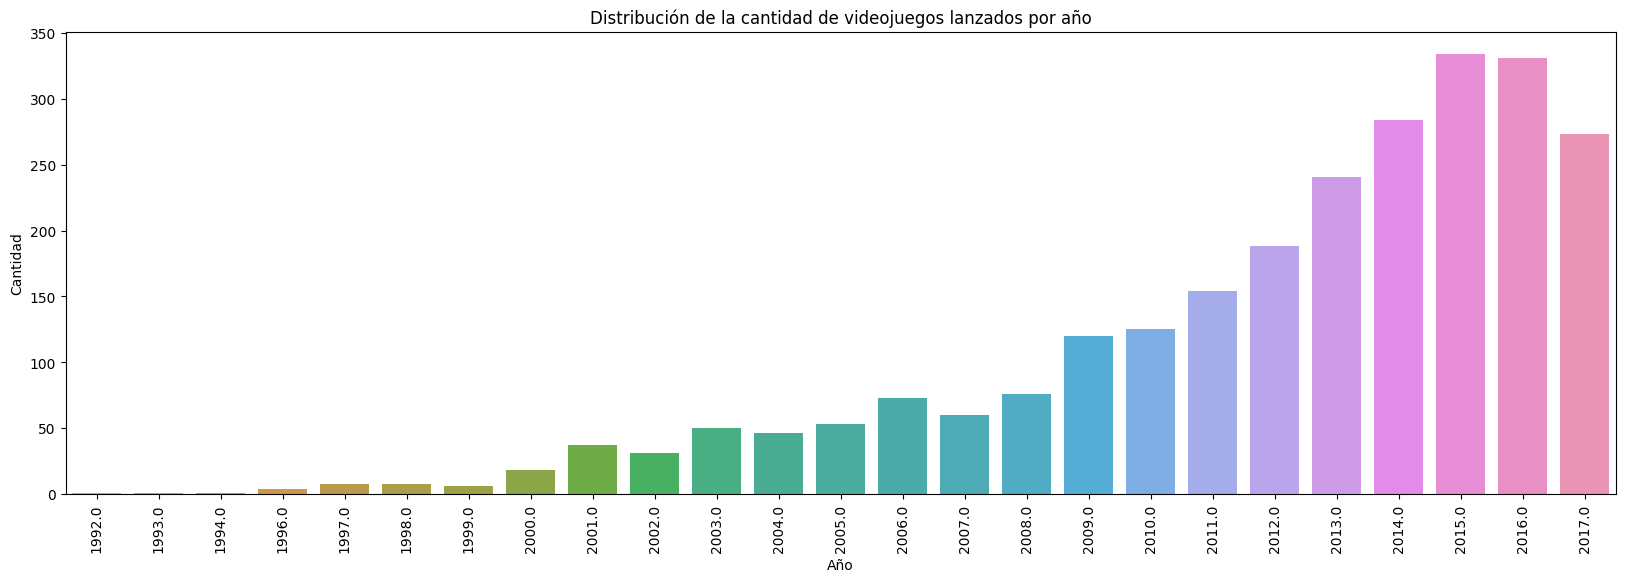

In [56]:
# Crear un gráfico de barras para visualizar el número de videojuegos lanzados por año
plt.figure(figsize=(20, 6))
sns.countplot(data=df2, x='year')
plt.xlabel('Año')
plt.ylabel('Cantidad')
plt.title('Distribución de la cantidad de videojuegos lanzados por año')
plt.xticks(rotation=90)
plt.show()

- El gráfico muestra la distribución de años de lanzamiento de los videojuegos. Cada barra representa un año y su altura indica la cantidad de videojuegos lanzados en ese año. Útil para tener una visión general de la distribución de los lanzamientos de videojuegos a lo largo del tiempo y para identificar patrones o tendencias en los años de lanzamiento.

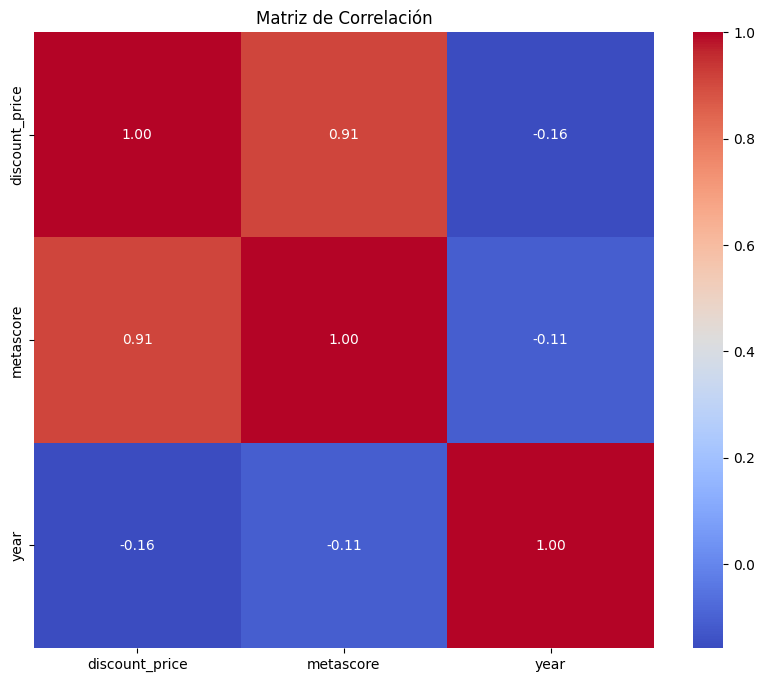

In [57]:
# Creamos una copia del DataFrame df2 solo con las columnas numéricas para calcular la matriz de correlación
numeric_df2 = df2.select_dtypes(include=[np.number])

# Calculamos la matriz de correlación
correlation_matrix2 = numeric_df2.corr()

# Crear un mapa de calor usando Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix2, annot=True, cmap='coolwarm', fmt=".2f")  # fmt=".2f" para mostrar 2 decimales en los valores de correlación
plt.title('Matriz de Correlación')
plt.show()

- Se visualiza una relación positiva muy fuerte entre el discount_price y el metascore (0.91), esto puede indicar que los videojuegos más caros son también los de mayor es la valoración.
- Se observa una relación negativa débil entre el año y el discount_price (-0.16) y entre el año y el metascore (-0.11). Esto puede indicar que los videojuegos más antiguos son más caros y mejor valorados que los más nuevos.
- No existe una correlación alta entre el año y ninguna de las otras dos variables. Esto puede indicar que los videojuegos no han cambiado mucho a lo largo del tiempo en términos de precio o calidad.


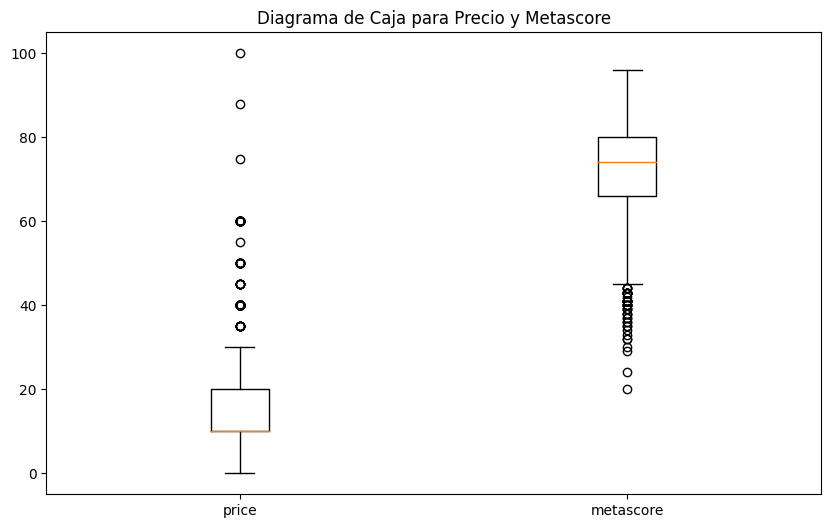

In [58]:
# Generar el diagrama de caja para 'price' y 'metascore'
plt.figure(figsize=(10, 6))
df_boxplot = df2[['price', 'metascore']]
plt.boxplot(df_boxplot.values, labels=df_boxplot.columns)
plt.title('Diagrama de Caja para Precio y Metascore')
plt.show()

- Ambas variables tienen varios valores atípicos, con algunos valores que caen fuera del rango de los bigotes. Esto significa que hay algunos casos extremos o inusuales en los datos.
- Price tiene una distribución más dispersa que metascore, podemos decir que hay más variabilidad en el precio que en el metascore.

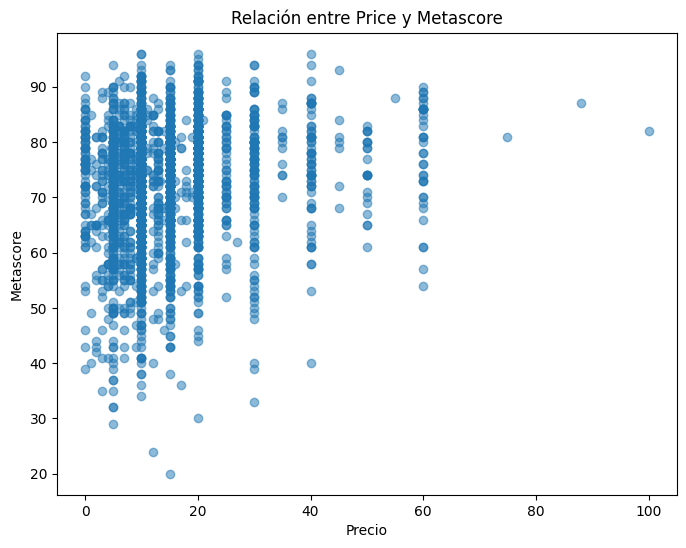

In [59]:
# Crear un gráfico de dispersión para visualizar la relación entre el precio y el metascore
plt.figure(figsize=(8, 6))
plt.scatter(df2['price'], df2['metascore'], alpha=0.5)
plt.xlabel('Precio')
plt.ylabel('Metascore')
plt.title('Relación entre Price y Metascore')
plt.show()

- No hay una relación clara o lineal entre price y metascore, ya que los puntos no forman una línea recta o una curva suave. Esto significa que price no es un buen predictor del metascore, y que hay otros factores que influyen en la calidad o la satisfacción del videojuego

# Modelado

In [61]:
# Eliminar filas con valores faltantes en las columnas de interés
df2 = df2.dropna(subset=["genres", "metascore", "year"])

# Convertir las variables categóricas a numéricas usando one-hot encoding
# Pero primero, si la columna "genres" contiene listas de géneros, vamos a desglosar esas listas
df2 = df2.explode("genres")

# Ahora aplicamos el one-hot encoding
df2 = pd.get_dummies(df2, columns=["genres"], drop_first=True)

# Dividir los datos en conjuntos de entrenamiento y prueba
X = df2[["metascore", "year"] + df2.filter(like="genres_").columns.tolist()]
y = df2["price"]  # Aquí debes elegir la columna que quieres predecir (en este caso he usado "price")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo de regresión lineal múltiple
linear_model = LinearRegression()

# Ajustar el modelo de regresión lineal con los datos de entrenamiento
linear_model.fit(X_train, y_train)

# Crear el modelo Bagging usando el modelo lineal como base
bagging_model = BaggingRegressor(base_estimator=linear_model, n_estimators=10, random_state=42)

# Entrenar el modelo Bagging con los mismos datos de entrenamiento
bagging_model.fit(X_train, y_train)

# Alinear las columnas de X_test con las del conjunto de entrenamiento X_train
X_test = X_test.align(X_train, axis=1, fill_value=0)[0]

# Realizar predicciones en el conjunto de prueba con el modelo Bagging
y_pred_bagging = bagging_model.predict(X_test)

# Calcular el RMSE con las predicciones del modelo Bagging
rmse_bagging = mean_squared_error(y_test, y_pred_bagging, squared=False)

print("RMSE del modelo Bagging:", rmse_bagging)

# Guardar el modelo Bagging en el archivo
modelo_guardado = "modelo_bagging.pkl"
with open(modelo_guardado, "wb") as file:
    pickle.dump(bagging_model, file)

RMSE del modelo Bagging: 9.031990168727825


C:\Users\unama\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


- Se usa el método Bagging que toma como base un modelo de regresión lineal múltiple que intenta predecir el precio de los videojuegos en función de su metascore, su año de lanzamiento y sus géneros. 
- Podemos ver que devuelve el RMSE que comparamos con otro modelos que descartamos.

In [67]:
# Cargar el modelo de Bagging desde el archivo con pickle
modelo_guardado = "modelo_bagging.pkl"
with open(modelo_guardado, "rb") as file:
    bagging_model = pickle.load(file)

# Definir el Enum para los géneros disponibles
class Genre(str, Enum):
    Action = "Action"
    Adventure = "Adventure"
    Casual = "Casual"
    Early_Access = "Early Access"
    Free_to_Play = "Free to Play"
    Indie = "Indie"
    Massively_Multiplayer = "Massively Multiplayer"
    RPG = "RPG"
    Racing = "Racing"
    Simulation = "Simulation"
    Sports = "Sports"
    Strategy = "Strategy"
    Video_Production = "Video Production"
    
# Cargar el DataFrame df2 con tus datos
df2 = pd.read_csv('Datasets\df2.csv')

# Crear una instancia de FastAPI
app = FastAPI()

# Definir X_train como las características utilizadas para entrenar el modelo
X_train = df2[["metascore", "year"] + df2.filter(like="genres_").columns.tolist()]
y_train = df2["price"]

# Función para realizar la predicción
def predict_price(metascore, year, genres):
    # Convertir la entrada a un DataFrame
    data = pd.DataFrame([[metascore, year, ",".join(genres)]], columns=["metascore", "year", "genres"])

    # Obtener las variables dummy de los géneros de la misma manera que se hizo durante el entrenamiento
    data_genres = data["genres"].str.get_dummies(sep=",")
    
    # Verificar si hay columnas faltantes en data_genres en comparación con X_train
    missing_columns = set(X_train.columns) - set(data_genres.columns)
    for column in missing_columns:
        data_genres[column] = 0

    # Asegurar el orden de las columnas en data_genres
    data_genres = data_genres[X_train.filter(like="genres_").columns]

    # Concatenar las variables dummy con el resto de las columnas
    data = pd.concat([data[["metascore", "year"]], data_genres], axis=1)

    # Realizar la predicción con el modelo de Bagging
    predicted_price = bagging_model.predict(data)[0]

    # Calcular el RMSE durante el entrenamiento del modelo
    y_pred_train = bagging_model.predict(X_train)
    rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)

    return predicted_price, rmse_train

# Definir el modelo de datos para la salida de la predicción
class PredictionOutput(BaseModel):
    predicted_price: float
    rmse: float

# Ruta para la predicción
@app.get("/predict/", response_model=PredictionOutput)
def predict(metascore: float, year: int, genres: Genre = None):
    # Obtener la predicción y el RMSE
    predicted_price, rmse_train = predict_price(metascore, year, genres.value)  # genres.value obtiene el valor del Enum

    # Crear un diccionario con el resultado
    result = {
        "predicted_price": predicted_price,
        "rmse": rmse_train
    }

    return result

- Esta es la función aplicada en la API, que devuelve la predicción del precio del videojuego y el RMSE del modelo usado.